In [1]:
# standard imports
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import datetime as dt
import sys
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# custom imports
sys.path.append('../src')
from fetch_range_data import fetch_range_data

# Bitcoin

The purpose of this notebook is to explore methods of bitcoin price forecasting

## Get today's data

In [2]:
# get today's data with custom function
today = dt.date.today() 
first_date = '2015/07/20'
btc = fetch_range_data('BTC/USD', first_date, today)

File exists, returned as df


In [3]:
btc.sort_index()

,date,unix,low,high,open,close,volume,vol_fiat
0,2015-12-21,1450656000,424.66,444.44,442.36,436.81,6845.941204,2.990376e+06
1,2015-12-20,1450569600,430.00,461.30,461.29,442.22,8376.433353,3.704226e+06
2,2015-12-19,1450483200,451.58,465.60,463.14,461.29,6991.384363,3.225056e+06
3,2015-12-18,1450396800,453.28,465.10,455.50,463.17,5045.110025,2.336744e+06
4,2015-12-17,1450310400,446.01,456.33,453.96,455.50,6291.403941,2.865734e+06
...,...,...,...,...,...,...,...,...
2219,2020-11-29,1606608000,17535.26,18359.00,17736.10,18202.04,8932.250291,1.625852e+08
2220,2020-11-28,1606521600,16880.00,17933.25,17155.43,17739.85,13157.951965,2.334201e+08
2221,2020-11-27,1606435200,16400.00,17475.00,17169.99,17153.95,23333.984298,4.002700e+08
2222,2020-11-26,1606348800,16200.00,18915.48,18717.24,17170.00,48644.170782,8.352204e+08


## Relabel Data

### Explore special values for BTC

In [4]:
# rename columns of btc dataframe
btc.pop('unix')
my_dict = {'date': 'Date', 'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume':'Volume', 'vol_fiat':'Market Cap'}
btc.rename(columns=my_dict, inplace=True)

btc.shape

(2224, 7)

### Convert Index to Datetime

In [5]:
btc.head()

,Date,Low,High,Open,Close,Volume,Market Cap
0,2015-12-21,424.66,444.44,442.36,436.81,6845.941204,2.990376e+06
1,2015-12-20,430.00,461.30,461.29,442.22,8376.433353,3.704226e+06
2,2015-12-19,451.58,465.60,463.14,461.29,6991.384363,3.225056e+06
3,2015-12-18,453.28,465.10,455.50,463.17,5045.110025,2.336744e+06
4,2015-12-17,446.01,456.33,453.96,455.50,6291.403941,2.865734e+06


In [6]:
# # change btc index to Date column datetime objects
if "Date" in btc.columns:
    btc.set_index(pd.to_datetime(btc['Date']),inplace=True)
    btc.pop('Date')

In [7]:
# sort index for ease of comparison
btc.sort_index(inplace=True)
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-08-20,227.45,238.20,227.46,235.56,8819.525082,2.077527e+06
2015-08-21,231.15,236.99,235.56,232.85,8328.577903,1.939309e+06
2015-08-22,222.68,235.53,232.85,231.15,7197.349489,1.663667e+06
2015-08-23,226.15,233.25,231.16,229.21,4312.637690,9.884997e+05
2015-08-24,210.00,229.24,229.23,211.16,16523.789445,3.489163e+06
...,...,...,...,...,...,...
2021-09-16,47020.82,48499.99,48144.03,47753.16,11739.279666,5.605877e+08
2021-09-17,46752.67,48176.64,47753.15,47303.50,9088.569565,4.299212e+08
2021-09-18,47050.00,48825.62,47306.87,48314.56,7491.034492,3.619260e+08


In [8]:
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-08-20,227.45,238.20,227.46,235.56,8819.525082,2.077527e+06
2015-08-21,231.15,236.99,235.56,232.85,8328.577903,1.939309e+06
2015-08-22,222.68,235.53,232.85,231.15,7197.349489,1.663667e+06
2015-08-23,226.15,233.25,231.16,229.21,4312.637690,9.884997e+05
2015-08-24,210.00,229.24,229.23,211.16,16523.789445,3.489163e+06
...,...,...,...,...,...,...
2021-09-16,47020.82,48499.99,48144.03,47753.16,11739.279666,5.605877e+08
2021-09-17,46752.67,48176.64,47753.15,47303.50,9088.569565,4.299212e+08
2021-09-18,47050.00,48825.62,47306.87,48314.56,7491.034492,3.619260e+08


In [9]:
type(btc.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [10]:
btc.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

### Resampling

In [11]:
btcM = btc.resample('M').mean()
btcM

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-08-31,221.719167,233.438333,227.920833,228.214167,9008.466745,2.038428e+06
2015-09-30,231.936000,236.955000,234.163000,234.365000,6386.535932,1.495726e+06
2015-10-31,261.374839,269.491613,263.724516,266.229032,7850.672554,2.159975e+06
2015-11-30,334.626000,362.877000,347.445000,349.508000,12491.747698,4.548917e+06
2015-12-31,410.983871,432.085161,422.848065,424.606129,14542.029645,6.299578e+06
...,...,...,...,...,...,...
2021-05-31,44270.166129,48889.056129,47119.199677,46457.782903,29742.506763,1.294962e+09
2021-06-30,34303.263667,37144.137000,35916.499000,35842.765667,19942.838788,7.051311e+08
2021-07-31,33364.951290,35217.746129,34236.297097,34443.391290,11984.850339,4.212497e+08


In [12]:
btcD = btcM.resample('D').mean()
btcD

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-08-31,221.719167,233.438333,227.920833,228.214167,9008.466745,2.038428e+06
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-04,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-09-26,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-27,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28,NaN,NaN,NaN,NaN,NaN,NaN


# Visualizations

In [13]:
# create xticklabels
xticks_min = []
xticks_maj = []
xlabels_min = []
xlabels_maj = []
year = 0
month = 0

for index in btc.index:
    if year != index.year:
        year = index.year
        xticks_maj.append(index)
        xlabels_maj.append(year)
    if month != index.month:
        month = index.month
        xticks_min.append(index)
        xlabels_min.append(month)


Text(0.5, 1.0, 'Bitcoin Price over Time')

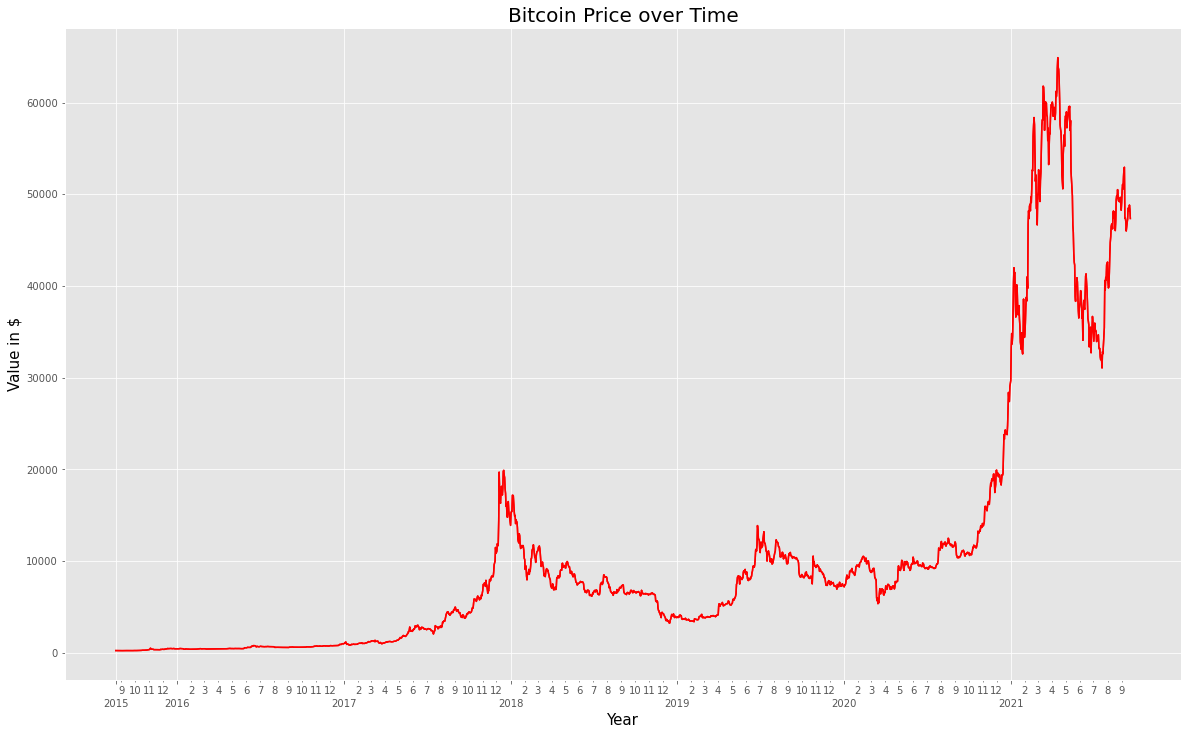

In [14]:
# plot daily high values of data
plt.style.use('ggplot')
figsize = (20,12)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(btc.index, btc.High, c='r', lw=1.5)
ax.plot(btc.index, btc.High, c='r', lw=1.5)

ax.set_xticks(xticks_min, minor=True)
ax.set_xticklabels(xlabels_min, minor=True)
ax.set_xticks(xticks_maj, minor=False)
ax.set_xticklabels(xlabels_maj, minor=False)

ax.tick_params(axis='x', which='major', direction='out', rotation=0, pad=15)
ax.tick_params(axis='x', which='minor', direction='out', rotation=0)

ax.set_xlabel("Year", fontsize=15, color='black')
ax.set_ylabel('Value in $', fontsize=15, color='black')
ax.set_title('Bitcoin Price over Time', fontsize=20, color='black')
# plt.savefig('bitcoin_historical_transparent.png', transparent=True, dpi=400)
# plt.savefig('bitcoin_historical.png', transparent=False, dpi=400)

Text(0.5, 1.0, 'Bitcoin Daily Closing Price')

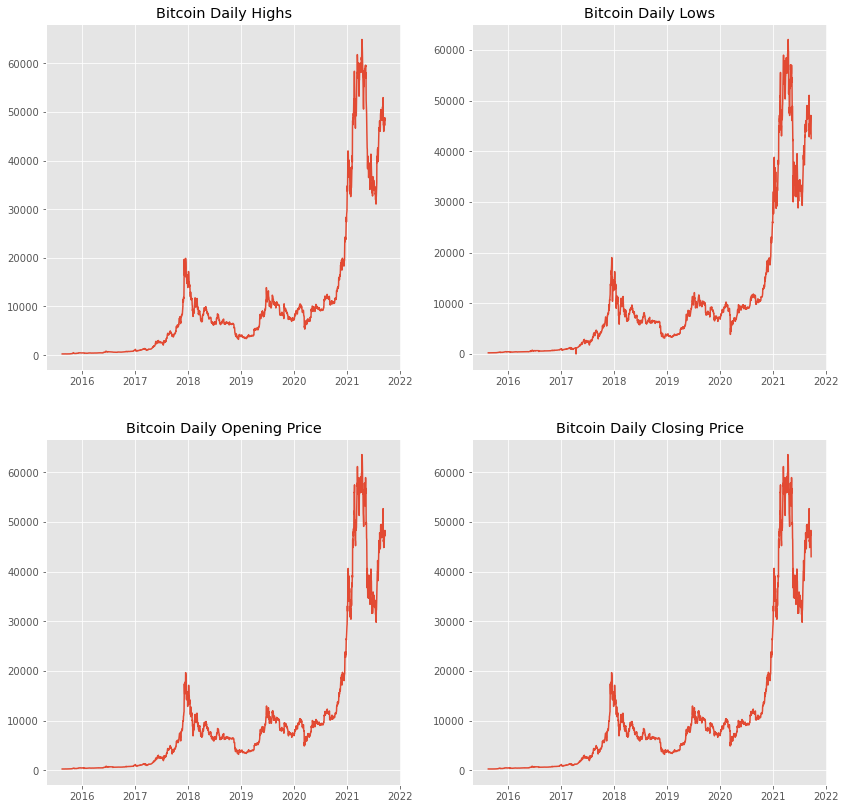

In [15]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening Price')
ax[1,1].set_title('Bitcoin Daily Closing Price')

Text(0.5, 1.0, 'Bitcoin Daily Closing')

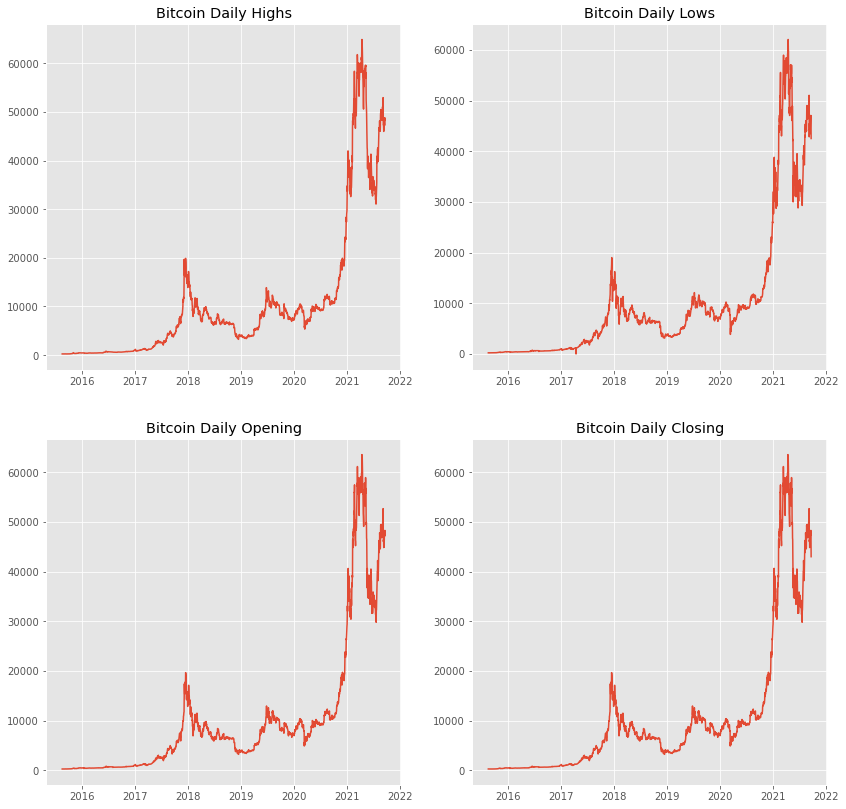

In [16]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening')
ax[1,1].set_title('Bitcoin Daily Closing')

# First Simple Model - Random Walk

In [17]:
end_of_train_index = int(btc.shape[0]*0.8)
end_of_train_index

1779

In [18]:
# separate train and test data
# roughly first 80% of data
train = btc.Close[:end_of_train_index]

# roughly last 20% of data
test = btc.Close[end_of_train_index:]

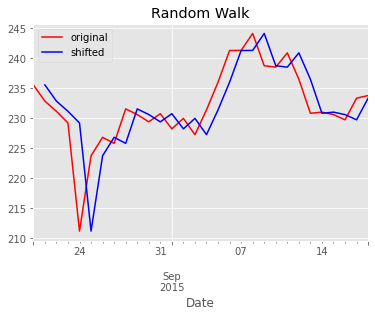

In [19]:
# create "random walk" model, shift values by 1 day
random_walk = train.shift(1)

# create plot of first 30 values of train and random walk
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [20]:
random_walk.dropna(inplace=True)

In [21]:
import sklearn.metrics as metric

In [22]:
train.shape[0]

1779

In [23]:
random_walk[:3]

Date
2015-08-21    235.56
2015-08-22    232.85
2015-08-23    231.15
Name: Close, dtype: float64

In [24]:
train[:3]

Date
2015-08-20    235.56
2015-08-21    232.85
2015-08-22    231.15
Name: Close, dtype: float64

In [25]:
train.index

DatetimeIndex(['2015-08-20', '2015-08-21', '2015-08-22', '2015-08-23',
               '2015-08-24', '2015-08-25', '2015-08-26', '2015-08-27',
               '2015-08-28', '2015-08-29',
               ...
               '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26',
               '2020-06-27', '2020-06-28', '2020-06-29', '2020-06-30',
               '2020-07-01', '2020-07-02'],
              dtype='datetime64[ns]', name='Date', length=1779, freq=None)

In [26]:
random_walk.index

DatetimeIndex(['2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30',
               ...
               '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26',
               '2020-06-27', '2020-06-28', '2020-06-29', '2020-06-30',
               '2020-07-01', '2020-07-02'],
              dtype='datetime64[ns]', name='Date', length=1778, freq=None)

In [35]:
random_walk

Date
2015-08-21     235.56
2015-08-22     232.85
2015-08-23     231.15
2015-08-24     229.21
2015-08-25     211.16
               ...   
2020-06-28    9002.46
2020-06-29    9113.24
2020-06-30    9184.45
2020-07-01    9136.20
2020-07-02    9239.97
Name: Close, Length: 1778, dtype: float64

In [37]:
train

Date
2015-08-20     235.56
2015-08-21     232.85
2015-08-22     231.15
2015-08-23     229.21
2015-08-24     211.16
               ...   
2020-06-28    9113.24
2020-06-29    9184.45
2020-06-30    9136.20
2020-07-01    9239.97
2020-07-02    9091.53
Name: Close, Length: 1779, dtype: float64

In [38]:
metric.mean_squared_error(train[1:], random_walk)

95411.49854370077

In [39]:
metric.mean_squared_log_error(train[1:], random_walk)

0.0016642765319406084

## ARIMA MODEL

In [40]:
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit

In [41]:
# create timeseriessplit object
data = btc.Close
n = 5
tss = TimeSeriesSplit(n_splits = n)
split_data = tss.split(data)

In [42]:
# save split data for time series cross val
i = 0
tss_train = []
tss_test = []
for j, k in split_data:
    # use globals to save 
    tss_train.append(j)
    tss_test.append(k)
    
tss_train = np.array(tss_train)
tss_test = np.array(tss_test)

<ipython-input-42-a5b0db9321a8>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tss_train = np.array(tss_train)


In [43]:
# define function to print min and max of array/list
def print_info(input_):
    min_value = min(input_) 
    max_value = max(input_)
    
    return f'min: {min_value} max: {max_value}\n'

In [44]:
# iterate through timeseriessplit object and print info
for train_index, test_index in tss.split(data):
    print('Train:', print_info(train_index))
    print('Test:', print_info(test_index))

Train: min: 0 max: 373

Test: min: 374 max: 743

Train: min: 0 max: 743

Test: min: 744 max: 1113

Train: min: 0 max: 1113

Test: min: 1114 max: 1483

Train: min: 0 max: 1483

Test: min: 1484 max: 1853

Train: min: 0 max: 1853

Test: min: 1854 max: 2223



In [45]:
for i in tss_train:
    print(max(i))

373
743
1113
1483
1853


In [46]:
for i in tss_test:
    print(max(i))

743
1113
1483
1853
2223


In [47]:
test_index[1]

1855

### Random Walk with ARIMA

In [48]:
x = btc['Close'].iloc[train_index[0]]
x
# x.append(btc['Close'].iloc[train_index[1]])
# x

235.56

In [49]:
# create endog and exog variables for fitting
endog = train
endog.index = train.index.to_period('D')

In [50]:
# CREATE arima_model object, pass training set and order

# (0,1,0) as the order means 1st order differenced model, essentially a random walk

rw = ARIMA(endog, order=(0,1,0)).fit()

y_hat = rw.predict(typ='levels')
y_hat

Date
2015-08-20       0.00
2015-08-21     235.56
2015-08-22     232.85
2015-08-23     231.15
2015-08-24     229.21
               ...   
2020-06-28    9002.46
2020-06-29    9113.24
2020-06-30    9184.45
2020-07-01    9136.20
2020-07-02    9239.97
Freq: D, Length: 1779, dtype: float64

In [51]:
# find squared error and compare to random walk model generated manually
metric.mean_squared_error(train[:], y_hat)

95389.05729302976

### 1st Order ARIMA

In [52]:
# # create endog and exog variables for fitting
# endog = train
# endog.index = endog.index.to_period('D')

In [53]:
btc.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [54]:
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-08-20,227.45,238.20,227.46,235.56,8819.525082,2.077527e+06
2015-08-21,231.15,236.99,235.56,232.85,8328.577903,1.939309e+06
2015-08-22,222.68,235.53,232.85,231.15,7197.349489,1.663667e+06
2015-08-23,226.15,233.25,231.16,229.21,4312.637690,9.884997e+05
2015-08-24,210.00,229.24,229.23,211.16,16523.789445,3.489163e+06
...,...,...,...,...,...,...
2021-09-16,47020.82,48499.99,48144.03,47753.16,11739.279666,5.605877e+08
2021-09-17,46752.67,48176.64,47753.15,47303.50,9088.569565,4.299212e+08
2021-09-18,47050.00,48825.62,47306.87,48314.56,7491.034492,3.619260e+08


In [55]:
endog

Date
2015-08-20     235.56
2015-08-21     232.85
2015-08-22     231.15
2015-08-23     229.21
2015-08-24     211.16
               ...   
2020-06-28    9113.24
2020-06-29    9184.45
2020-06-30    9136.20
2020-07-01    9239.97
2020-07-02    9091.53
Freq: D, Name: Close, Length: 1779, dtype: float64

In [56]:
# CREATE arima_model object, pass training set and order

# (1,1,0) as the order means 1st order differenced model, with additional lag

ar_1 = ARIMA(train, order=(1,1,0)).fit()

y_hat = ar_1.predict()
y_hat 

Date
2015-08-20       0.000000
2015-08-21     235.485267
2015-08-22     232.859866
2015-08-23     231.156189
2015-08-24     229.217063
                 ...     
2020-06-28    9003.016855
2020-06-29    9112.836702
2020-06-30    9184.190758
2020-07-01    9136.375656
2020-07-02    9239.592222
Freq: D, Length: 1779, dtype: float64

In [57]:
y_hat = ar_1.predict(start=test.index[0], end=test.index[-1])

In [58]:
btc.loc['2020-06-05']

Low           9.585440e+03
High          9.855000e+03
Open          9.791960e+03
Close         9.613210e+03
Volume        1.249590e+04
Market Cap    1.201257e+08
Name: 2020-06-05 00:00:00, dtype: float64

In [59]:
y_hat

2020-07-03    9092.070400
2020-07-04    9092.068433
2020-07-05    9092.068440
2020-07-06    9092.068440
2020-07-07    9092.068440
                 ...     
2021-09-16    9092.068440
2021-09-17    9092.068440
2021-09-18    9092.068440
2021-09-19    9092.068440
2021-09-20    9092.068440
Freq: D, Length: 445, dtype: float64

In [60]:
metric.mean_squared_error(train, y_hat[0]*np.ones(len(train)))

33394737.644923408

In [61]:
train

Date
2015-08-20     235.56
2015-08-21     232.85
2015-08-22     231.15
2015-08-23     229.21
2015-08-24     211.16
               ...   
2020-06-28    9113.24
2020-06-29    9184.45
2020-06-30    9136.20
2020-07-01    9239.97
2020-07-02    9091.53
Freq: D, Name: Close, Length: 1779, dtype: float64

In [62]:
# CREATE arima_model object, pass training set and order

# try higher order models

ar_2 = ARIMA(train,exog=None, order=(1,2,1)).fit()

y_hat = ar_2.predict(start = test.index[0], end = test.index[10])
y_hat

2020-07-03    9097.038062
2020-07-04    9102.025560
2020-07-05    9107.014818
2020-07-06    9112.004071
2020-07-07    9116.993323
2020-07-08    9121.982576
2020-07-09    9126.971828
2020-07-10    9131.961081
2020-07-11    9136.950333
2020-07-12    9141.939586
2020-07-13    9146.928838
Freq: D, dtype: float64

In [63]:
metric.mean_squared_error(test[0:11], y_hat)

23189.465609044648

In [64]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1779
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -12712.876
Date:                Tue, 21 Sep 2021   AIC                          25431.752
Time:                        22:21:52   BIC                          25448.200
Sample:                    08-20-2015   HQIC                         25437.827
                         - 07-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0034      0.009     -0.364      0.716      -0.022       0.015
ma.L1         -0.9999      0.023    -43.373      0.000      -1.045      -0.955
sigma2      9.545e+04   2189.761     43.591      0.000    9.12e+04    9.97e+04
===================================================================================
Ljung-Box (Q):                      121.01   Jarque-Bera (JB):             35223.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             241.48   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# additoinal ARIMIA model
ar_3 = ARIMA(train,exog=None, order=(4,2,3), freq='D').fit()

y_hat = ar_3.predict(typ='levels')
y_hat

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Date
2015-08-20       0.000000
2015-08-21     353.284664
2015-08-22     248.180167
2015-08-23     238.552965
2015-08-24     232.905901
                 ...     
2020-06-28    8994.197809
2020-06-29    9115.254505
2020-06-30    9209.210165
2020-07-01    9120.771573
2020-07-02    9255.378142
Freq: D, Length: 1779, dtype: float64

In [66]:
metric.mean_squared_error(train[:], y_hat)

94347.69220621261

In [67]:
# additoinal ARIMIA model
ar_4 = ARIMA(train, order=(1,1,4), freq='D').fit()

y_hat = ar_4.predict(typ='levels')
metric.mean_squared_error(train[:], y_hat)

95087.5683222258

In [68]:
TimeSeriesSplit(5, btc['Close'], max_train_size=0.8*btc.shape[0])

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass max_train_size=Date
2015-08-20      235.56
2015-08-21      232.85
2015-08-22      231.15
2015-08-23      229.21
2015-08-24      211.16
                ...   
2021-09-16    47753.16
2021-09-17    47303.50
2021-09-18    48314.56
2021-09-19    47255.92
2021-09-20    43012.97
Name: Close, Length: 2224, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TimeSeriesSplit(max_train_size=Date
2015-08-20      235.56
2015-08-21      232.85
2015-08-22      231.15
2015-08-23      229.21
2015-08-24      211.16
                ...
2021-09-16    47753.16
2021-09-17    47303.50
2021-09-18    48314.56
2021-09-19    47255.92
2021-09-20    43012.97
Name: Close, Length: 2224, dtype: float64,
        n_splits=5)

### Make function to make data reshaping easier

In [69]:
# function converts data to array and reshapes for linreg compatibility 
def arr_shape(data):
    data = np.array(data)
    data = data.reshape(-1,1)
    return data

## auto_arima

In [70]:
arima_model = auto_arima(train,
                         start_p=0,d=0,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[96] intercept   : AIC=31751.249, Time=3.81 sec
 ARIMA(1,0,0)(1,1,0)[96] intercept   : AIC=inf, Time=284.65 sec


KeyboardInterrupt: 

In [ ]:
non_auto_arima = SARIMAX(train,
                        order=(1,1,0),
                        seasonal_order=(1,1,1,96),
                        freq='D').fit()

In [ ]:
non_auto_arima = SARIMAX(train,
                        order=(0,0,0),
                        seasonal_order=(0,1,0,96),
                        freq='D').fit()

In [ ]:
y_pred = non_auto_arima.predict(start='2020-06-05')

In [ ]:
y_pred

In [ ]:
train

In [ ]:
test[0]

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
btc.shape

In [ ]:
btc.Close

In [ ]:
close = btc.Close
close.reset_index(drop=True, inplace=True)
close_index = close.index
close = np.squeeze(close.to_numpy())
close_index = np.squeeze(close_index.to_numpy())

In [ ]:
close_index[0]

In [ ]:
# # separate data for linear regression
X_train, X_test, y_train, y_test = train_test_split(close_index, close)

# reshape for linreg
X_train = arr_shape(X_train)
X_test = arr_shape(X_test)
y_train = arr_shape(y_train)
y_test = arr_shape(y_test)


In [ ]:
y_train

In [ ]:
X_train

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
preds = lr.predict(X_test)

In [ ]:
lr.intercept_

In [ ]:
lr.coef_

## Polynomial Features

In [71]:
from sklearn.preprocessing import PolynomialFeatures as pf

In [72]:
# resample data to weekly
btcW = btc.resample('W').mean()

In [73]:
# find 4th order fit for weekly data
poly = pf(4)
poly.fit_transform((btcW.index, btcW.Close))

array([[1.00000000e+00, 1.44028800e+18, 1.44089280e+18, ...,
        7.09925316e+72, 7.10188405e+72, 7.10451591e+72],
       [1.00000000e+00, 2.32192500e+02, 2.25578571e+02, ...,
        4.13300171e+18, 3.76124527e+18, 3.42292769e+18]])

In [ ]:
poly?

In [ ]:
poly.powers_

## Get 4th order polynomial fit for monthly data

In [ ]:
poly = pf(4)
poly.fit_transform((btcM.index, btcM.Close))

In [ ]:
poly.powers_